# ODE-Solvers from Scratch

All the other tutorials show how to use the ODE-solver with the `probsolve_ivp` function.
This is great, though `probnum` has more customisation to offer.

In [1]:
from probnum import diffeq, filtsmooth, statespace, randvars
import numpy as np

import matplotlib.pyplot as plt
plt.style.use("../../probnum.mplstyle")

First we define the ODE problem. As always, we use Lotka-Volterra. Once the ODE functions are defined, they are gathered in an `IVP` object.

In [2]:

def f(t, y):
    y1, y2 = y
    return np.array([0.5 * y1 - 0.05 * y1 * y2, -0.5 * y2 + 0.05 * y1 * y2])

def df(t, y):
    y1, y2 = y
    return np.array([[0.5 - 0.05 * y2, -0.05 * y1], [0.05 * y2, -0.5 + 0.05 * y1]])

t0 = 0.
tmax = 15.
y0 = np.array([20, 20])

ivp = diffeq.IVP((t0, tmax), initrv=randvars.Constant(y0), rhs=f, jac=df)


Next, we define a prior distribution and a measurement model. The former can be any `Integrator`, which currently restricts the choice to `IBM`, `IOUP`, and `Matern`. We usually recommend `IBM`.
The measurement model requires a choice between EK0, EK1 (extended Kalman filters of order 0 or 1, respectively) and perhaps UK (unscented Kalman filter). The use of the latter is discouraged, because the square-root implementation is not available currently.

The measurement model can either be constructed with `DiscreteEKFComponent.from_ode` or, perhaps more conveniently, with `GaussianIVPFilter.string_to_measurement_model`.  

In [3]:
prior = statespace.IBM(ordint=4, spatialdim=ivp.dimension, forward_implementation="sqrt", backward_implementation="sqrt")
ekf = diffeq.GaussianIVPFilter.string_to_measurement_model("EK1", ivp=ivp, dynamics_model=prior)


Next, we construct the ODE filter. One choice that has not been made yet is the initialiation strategy. The current default choice is to initialise by fitting the prior to a few steps of a Runge-Kutta solution. An alternative is to use automatic differentiation, which is currently in development.
An easy-access version of those initialisation strategies is to use the constructor `GaussianIVPFilter.construct_with_rk_init`. 

In [8]:
diffmodel =diffeq.ConstantDiffusion()
solver = diffeq.GaussianIVPFilter.construct_with_rk_init(ivp, dynamics_model=prior, measurement_model=ekf, diffusion_model=diffmodel, with_smoothing=False)


Now we can solve the ODE. To this end, define a `StepRule`, e.g. `ConstantSteps` or `AdaptiveSteps`. If you don't know which firststep to use, the function `propose_firststep` makes an educated guess for you.

In [9]:
firststep = diffeq.propose_firststep(ivp)
steprule = diffeq.AdaptiveSteps(firststep=firststep, atol=1e-3, rtol=1e-3)
# steprule = diffeq.ConstantSteps(0.1)
odesol = solver.solve(steprule=steprule)

`GaussianIVPFilter.solve` returns an `ODESolution` object, which is sliceable and callable. The latter can be used to plot the solution on a uniform grid, even though the solution was computed on an adaptive grid. Be careful: the return values of `__call__`, etc., are always random variable-like objects. We decide to plot the mean.

In [10]:
evalgrid = np.arange(ivp.t0, ivp.tmax, step=0.1)


Done! This is the solution to the Lotka-Volterra model.

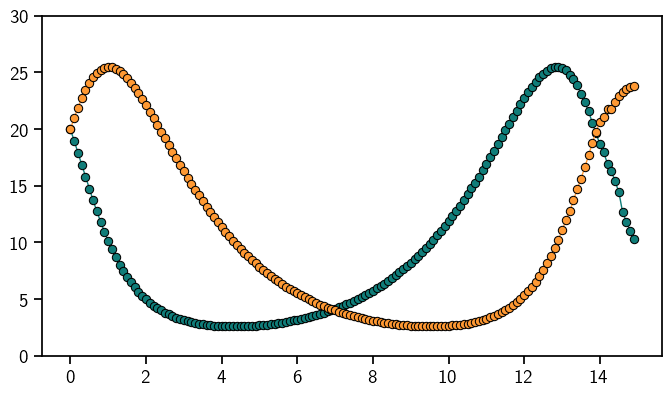

In [11]:
sol = odesol(evalgrid)

plt.plot(evalgrid, sol.mean, "o-", linewidth=1)
plt.ylim((0, 30))
plt.show()